# Smart Farming Data Analysis

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [34]:
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/smart-farming-sensor-data-for-yield-prediction/Smart_Farming_Crop_Yield_2024.csv


# Download The Data

In [35]:
df = pd.read_csv('/kaggle/input/smart-farming-sensor-data-for-yield-prediction/Smart_Farming_Crop_Yield_2024.csv')
df.head()

,farm_id,region,crop_type,soil_moisture_%,soil_pH,temperature_C,rainfall_mm,humidity_%,sunlight_hours,irrigation_type,...,sowing_date,harvest_date,total_days,yield_kg_per_hectare,sensor_id,timestamp,latitude,longitude,NDVI_index,crop_disease_status
0,FARM0001,North India,Wheat,35.95,5.99,17.79,75.62,77.03,7.27,NaN,...,2024-01-08,2024-05-09,122,4408.07,SENS0001,2024-03-19,14.970941,82.997689,0.63,Mild
1,FARM0002,South USA,Soybean,19.74,7.24,30.18,89.91,61.13,5.67,Sprinkler,...,2024-02-04,2024-05-26,112,5389.98,SENS0002,2024-04-21,16.613022,70.869009,0.58,NaN
2,FARM0003,South USA,Wheat,29.32,7.16,27.37,265.43,68.87,8.23,Drip,...,2024-02-03,2024-06-26,144,2931.16,SENS0003,2024-02-28,19.503156,79.068206,0.80,Mild
3,FARM0004,Central USA,Maize,17.33,6.03,33.73,212.01,70.46,5.03,Sprinkler,...,2024-02-21,2024-07-04,134,4227.80,SENS0004,2024-05-14,31.071298,85.519998,0.44,NaN
4,FARM0005,Central USA,Cotton,19.37,5.92,33.86,269.09,55.73,7.93,NaN,...,2024-02-05,2024-05-20,105,4979.96,SENS0005,2024-04-13,16.568540,81.691720,0.84,Severe


# 📑Data Preparation

In [36]:
print(df.head())
print(df.info())
print(df.describe())

    farm_id       region crop_type  soil_moisture_%  soil_pH  temperature_C  \
0  FARM0001  North India     Wheat            35.95     5.99          17.79   
1  FARM0002    South USA   Soybean            19.74     7.24          30.18   
2  FARM0003    South USA     Wheat            29.32     7.16          27.37   
3  FARM0004  Central USA     Maize            17.33     6.03          33.73   
4  FARM0005  Central USA    Cotton            19.37     5.92          33.86   

   rainfall_mm  humidity_%  sunlight_hours irrigation_type  ... sowing_date  \
0        75.62       77.03            7.27             NaN  ...  2024-01-08   
1        89.91       61.13            5.67       Sprinkler  ...  2024-02-04   
2       265.43       68.87            8.23            Drip  ...  2024-02-03   
3       212.01       70.46            5.03       Sprinkler  ...  2024-02-21   
4       269.09       55.73            7.93             NaN  ...  2024-02-05   

   harvest_date total_days yield_kg_per_hectare  s

🧹Nulls and Duplicates

In [37]:
duplicate = df.duplicated().sum()
missing_row = df.isnull().sum()
print('Null Data:\n',missing_row)
print('Duplicate Rows:',duplicate)

Null Data:
 farm_id                   0
region                    0
crop_type                 0
soil_moisture_%           0
soil_pH                   0
temperature_C             0
rainfall_mm               0
humidity_%                0
sunlight_hours            0
irrigation_type         150
fertilizer_type           0
pesticide_usage_ml        0
sowing_date               0
harvest_date              0
total_days                0
yield_kg_per_hectare      0
sensor_id                 0
timestamp                 0
latitude                  0
longitude                 0
NDVI_index                0
crop_disease_status     130
dtype: int64
Duplicate Rows: 0


In [38]:
# Remove dulicated
if duplicate != 0:
    duplicate_rows = df[df.duplicated()]
    print(duplicate_rows)
    df_no_dupicates = df.drop_duplicates()
    print(df_no_dupicates.head())

Convert date columns to datetime

In [39]:
df['sowing_date'] = pd.to_datetime(df['sowing_date'])
df['harvest_date'] = pd.to_datetime(df['harvest_date'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

Verify total days

In [40]:
df['calcualted_days'] = (df['harvest_date'] - df['sowing_date']).dt.days
print("Calculated_day mathces total day:")
print((df['calcualted_days'] == df['total_days']).value_counts())

# If some value is discrepancies
if not (df['total_days'] == df['calcualted_days']).all():
    print("Some date is discrepancies")
    df['total_days'] = df['calcualted_days']
df.drop('calcualted_days',axis=1,inplace=True)

Calculated_day mathces total day:
True    500
Name: count, dtype: int64


# 🌽Exploratory Data Analysis (EDA)

Yeild Distribution

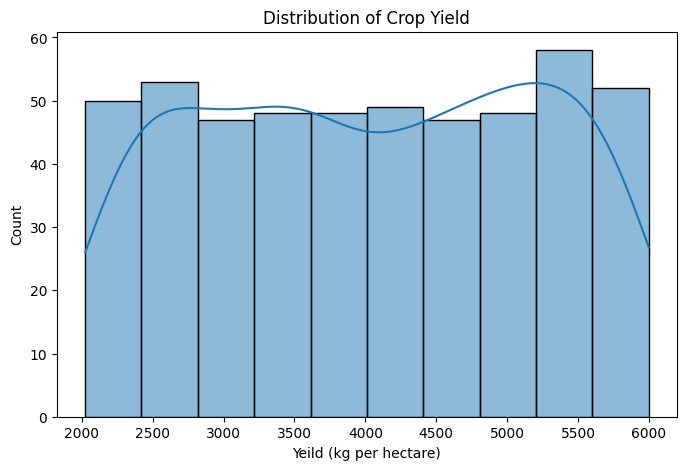

In [41]:
plt.figure(figsize=(8,5))
sns.histplot(df['yield_kg_per_hectare'],kde=True)
plt.title('Distribution of Crop Yield')
plt.xlabel('Yeild (kg per hectare)')
plt.show()
print("\n")

Yield by crop type

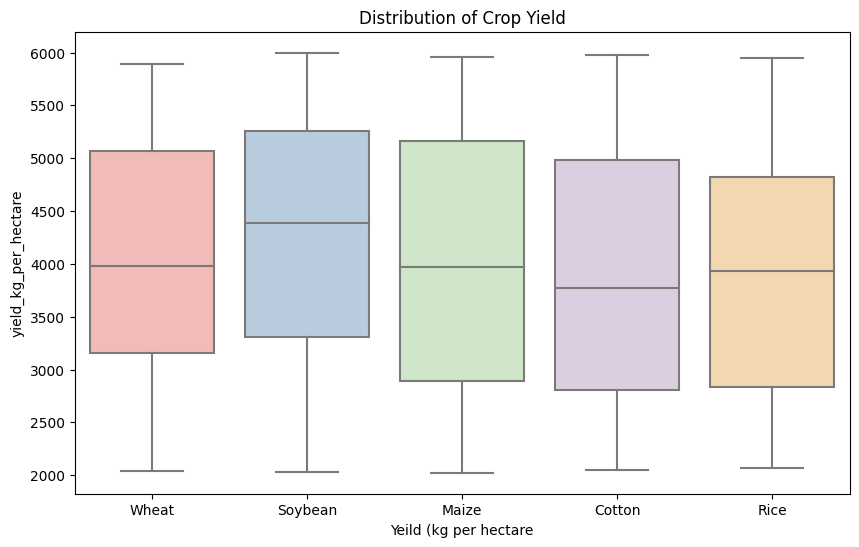

In [42]:
plt.figure(figsize=(10,6))
sns.boxplot(x='crop_type',y='yield_kg_per_hectare',data=df,palette='Pastel1')
plt.title('Distribution of Crop Yield')
plt.xlabel('Yeild (kg per hectare')
plt.show()
print("\n")

Yeild by region

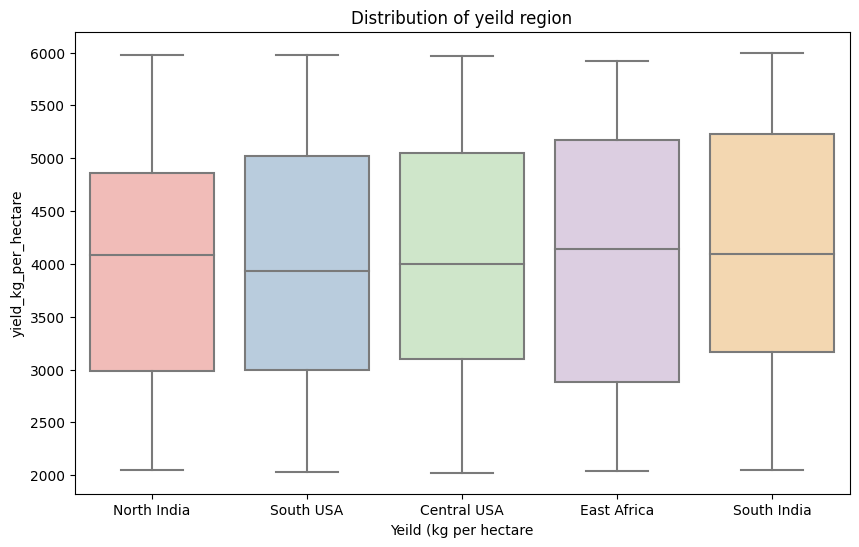

In [43]:
plt.figure(figsize=(10,6))
sns.boxplot(x='region',y='yield_kg_per_hectare',data=df,palette='Pastel1')
plt.title('Distribution of yeild region')
plt.xlabel('Yeild (kg per hectare')
plt.show()
print("\n")

Correlation Matrix

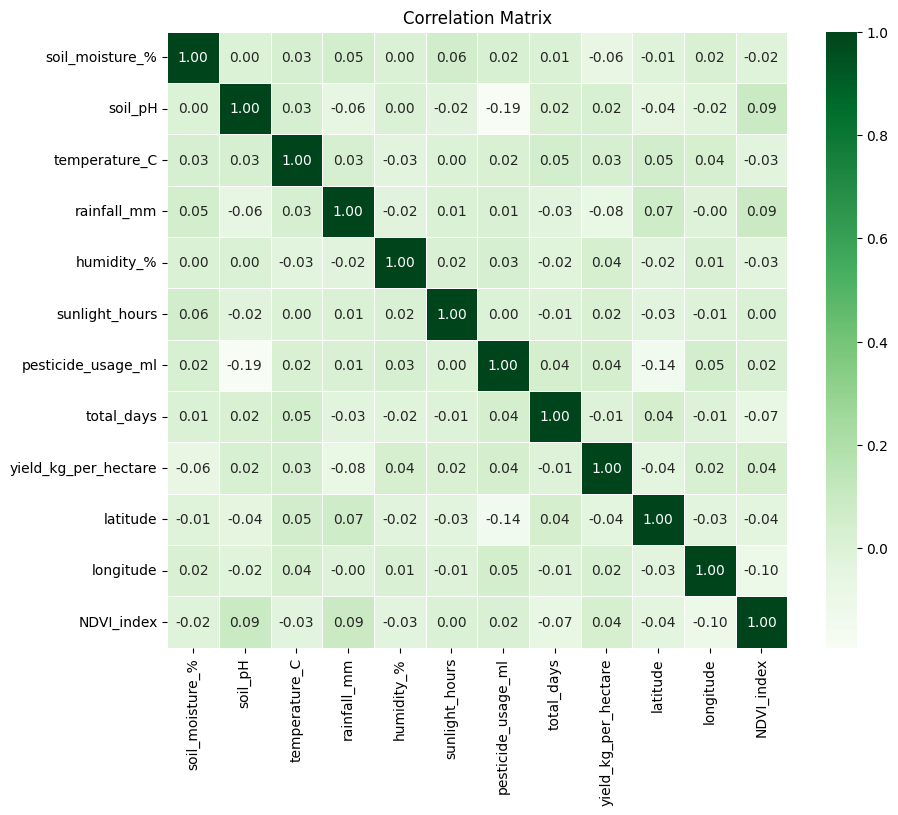

In [44]:
numeric_data = df.select_dtypes(include=['number'])
corr_matrix = numeric_data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,annot=True,cmap='Greens',fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()
print("\n")

Understanding the Relationship Between Environmental Variables and Crop Productivity

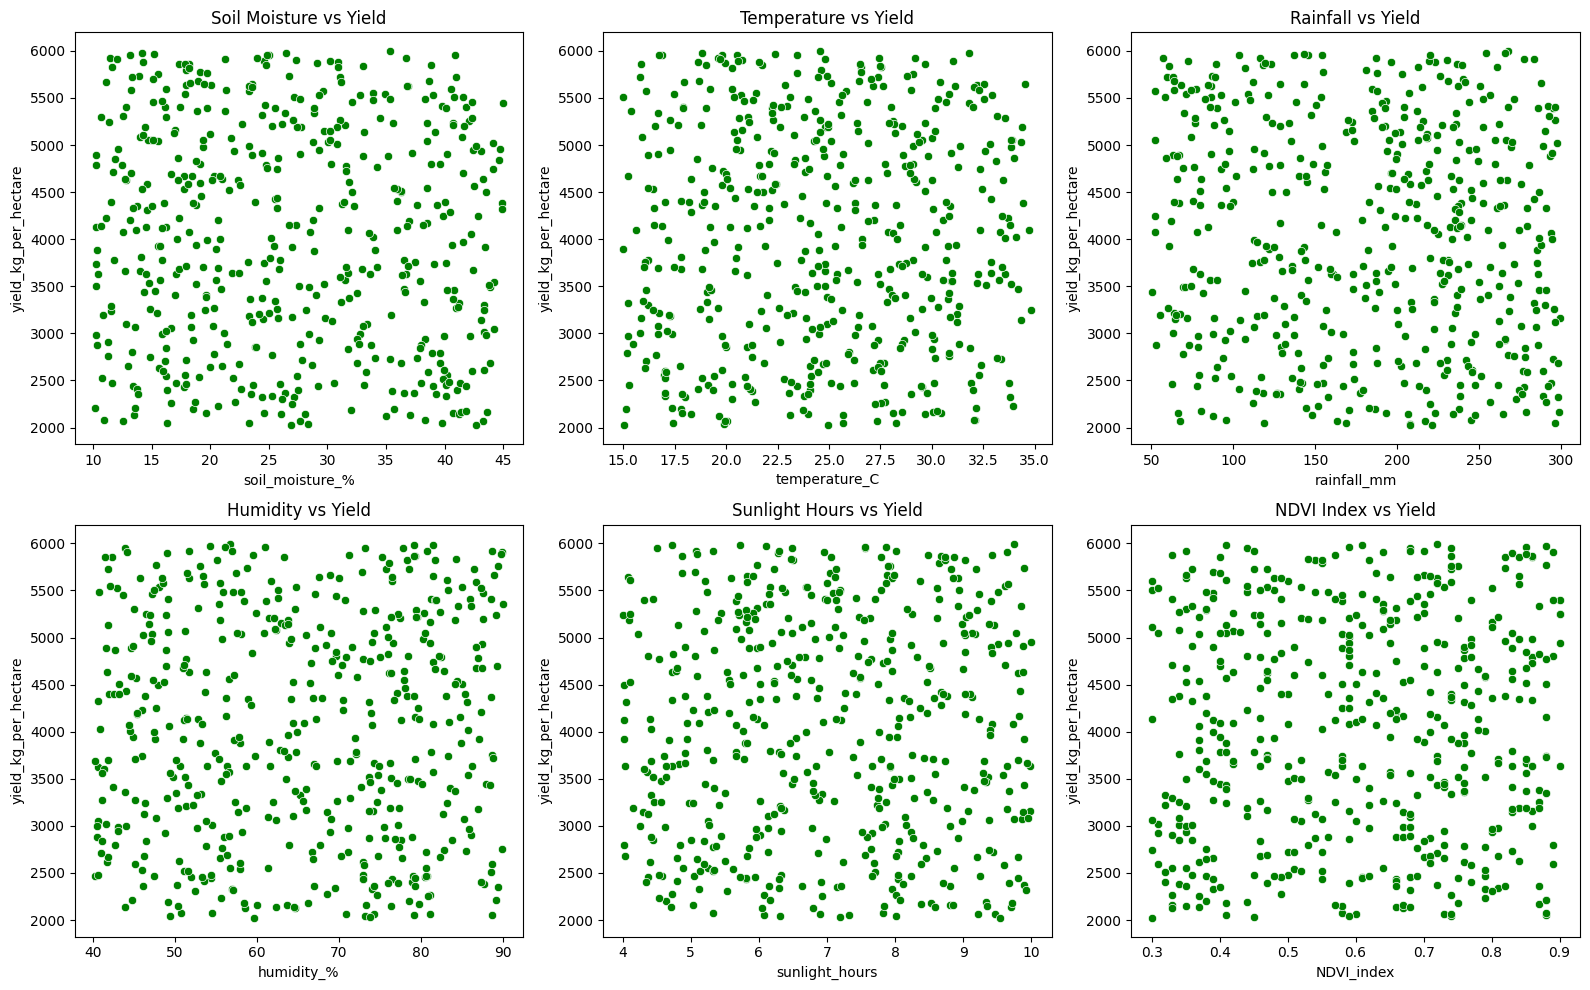

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

sns.scatterplot(x='soil_moisture_%', y='yield_kg_per_hectare', data=df, ax=axes[0],color='green')
axes[0].set_title('Soil Moisture vs Yield')

sns.scatterplot(x='temperature_C', y='yield_kg_per_hectare', data=df, ax=axes[1],color='green')
axes[1].set_title('Temperature vs Yield')

sns.scatterplot(x='rainfall_mm', y='yield_kg_per_hectare', data=df, ax=axes[2],color='green')
axes[2].set_title('Rainfall vs Yield')

sns.scatterplot(x='humidity_%', y='yield_kg_per_hectare', data=df, ax=axes[3],color='green')
axes[3].set_title('Humidity vs Yield')

sns.scatterplot(x='sunlight_hours', y='yield_kg_per_hectare', data=df, ax=axes[4],color='green')
axes[4].set_title('Sunlight Hours vs Yield')

sns.scatterplot(x='NDVI_index', y='yield_kg_per_hectare', data=df, ax=axes[5],color='green')
axes[5].set_title('NDVI Index vs Yield')

plt.tight_layout()
plt.show()
print("\n")

Analyzing impact of irrigation/fertilizer/crop disease on Agricultural Yield

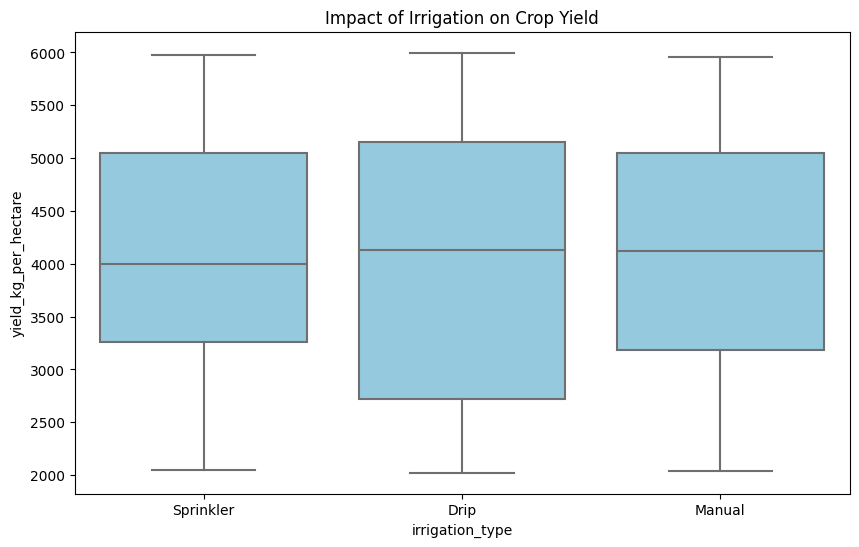

In [46]:
# Irrigation box plot
plt.figure(figsize=(10,6))
sns.boxplot(x='irrigation_type',y='yield_kg_per_hectare',data=df,color='skyblue')
plt.title('Impact of Irrigation on Crop Yield')
plt.show()

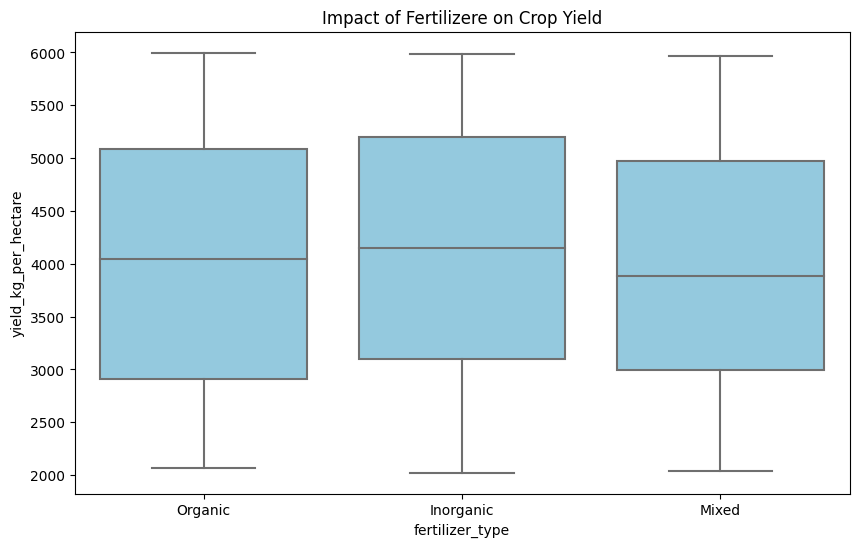

In [47]:
# Fertilizer box plot
plt.figure(figsize=(10,6))
sns.boxplot(x='fertilizer_type',y='yield_kg_per_hectare',data=df,color='skyblue')
plt.title('Impact of Fertilizere on Crop Yield')
plt.show()

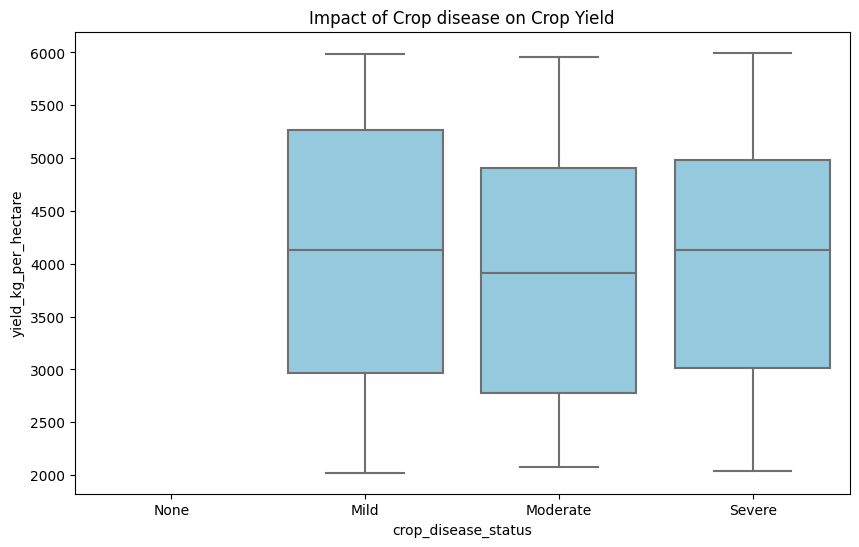

In [48]:
# Crop disease box plot
plt.figure(figsize=(10,6))
sns.boxplot(x='crop_disease_status',y='yield_kg_per_hectare',data=df,color='skyblue',
            order=['None', 'Mild', 'Moderate', 'Severe'])
plt.title('Impact of Crop disease on Crop Yield')
plt.show()

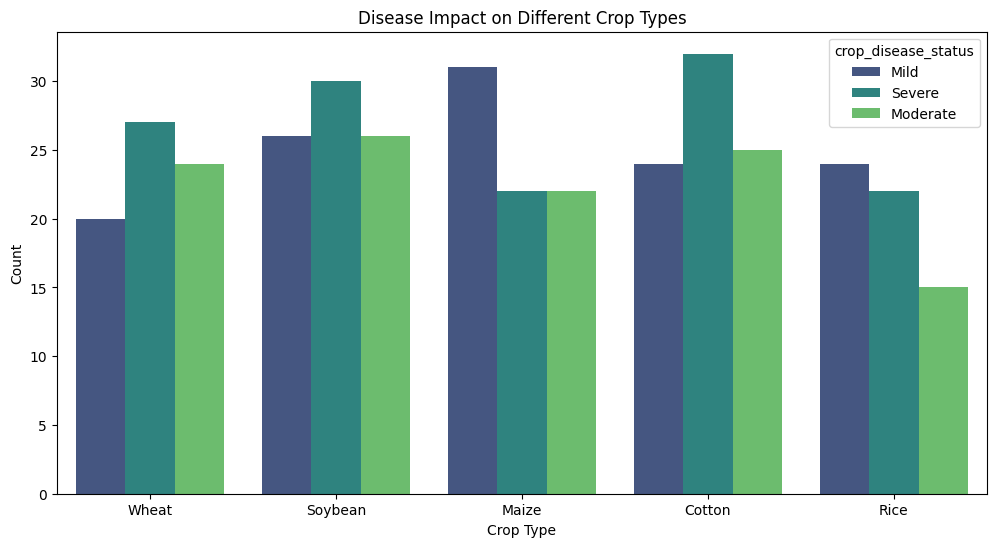

In [49]:
# Create a count plot to visualize the disease status distribution for all crop types, not just Maize
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='crop_type', hue='crop_disease_status', palette="viridis")

# Add titles and labels
plt.title('Disease Impact on Different Crop Types')
plt.xlabel('Crop Type')
plt.ylabel('Count')

# Show the plot
plt.show()

# 🤖Preparation for Training Model

One-Hot Encoding

In [50]:
categorical_colums = ['region','crop_type','irrigation_type','fertilizer_type','crop_disease_status'] # select string columns to use in features
df_encoded = pd.get_dummies(df,columns=categorical_colums,drop_first=True)# convert string to 0/1 and drop columns already create by use One-hot 
print('\n')

Feature Selection

In [51]:
feature = [col for col in df_encoded.columns if col not in ['farm_id','sowing_date','harvest_date','sensor_id',
                                                      'yield_kg_per_hectare','timestamp']] # select function
X = df_encoded[feature]
Y = df_encoded['yield_kg_per_hectare']

# Training Model

Multiple Linear Regression

In [52]:
# Spilt data 80% train 20% test
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

# Create regression Model
model = LinearRegression()

# Train model
model.fit(X_train,y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluatio Model
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_pred)
print(f'Mean Squared Error: {mse:.5f}')
print(f'Root Mean Squared Error: {rmse:.5f}')
print(f'R-squared: {r2:.5f}\n')


Mean Squared Error: 1494142.00484
Root Mean Squared Error: 1222.35102
R-squared: -0.08188



RandomForest

In [53]:
# Create RandomForest Model
f_model = RandomForestRegressor()

# Train feature Model
f_model.fit(X_train,y_train)

# Predict
yf_pred = f_model.predict(X_test)

# Evaluatio Model
fmse = mean_squared_error(y_test,yf_pred)
frmse = np.sqrt(fmse)
fr2 = r2_score(y_test,yf_pred)
print(f'Mean Squared Error: {fmse:.5f}')
print(f'Root Mean Squared Error: {frmse:.5f}')
print(f'R-squared: {fr2:.5f}')

Mean Squared Error: 1495988.44373
Root Mean Squared Error: 1223.10606
R-squared: -0.08322


In [54]:
# Top 10 importance features
important = f_model.feature_importances_

# create dataframe
feature_important = pd.DataFrame({
    'Feature':X.columns,
    'Importance':important})
feature_important = feature_important.sort_values(by='Importance',ascending=False).head(15)

# Show Top 10 features
print(feature_important.head(10))

               Feature  Importance
9            longitude    0.099028
6   pesticide_usage_ml    0.092217
0      soil_moisture_%    0.089819
3          rainfall_mm    0.086497
2        temperature_C    0.083909
5       sunlight_hours    0.080845
4           humidity_%    0.077041
10          NDVI_index    0.073396
8             latitude    0.071292
1              soil_pH    0.069748


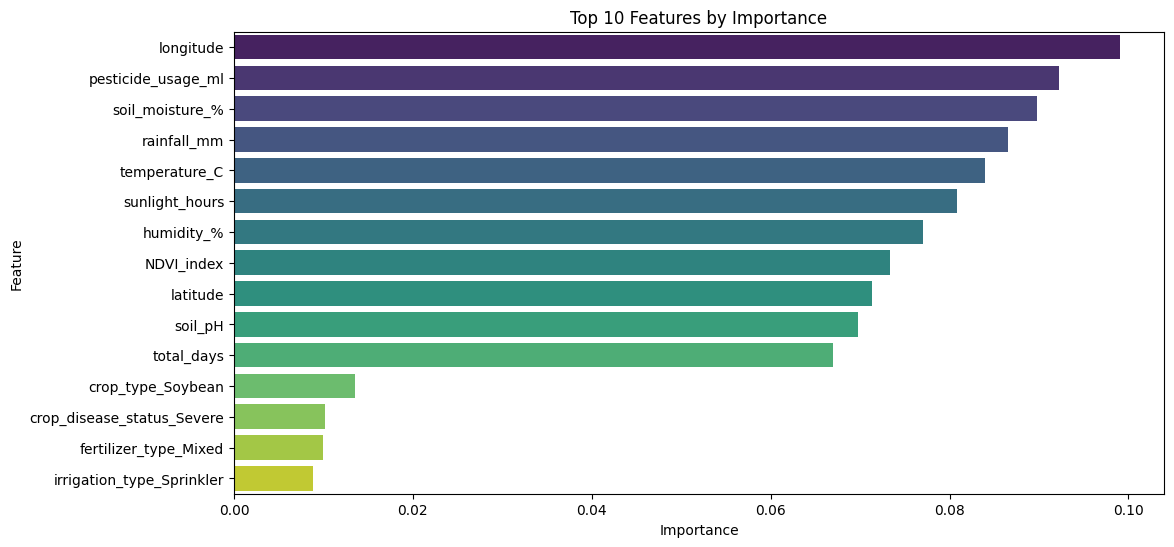

In [55]:
# Graph show Feature Importance
plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feature_important, palette='viridis')
plt.xlabel('Importance')
plt.title('Top 10 Features by Importance')
plt.show()

Yield estimation based on crop type and geographical region

In [56]:
print('Yield estimation based on crop type and geographical region')
t_df = df.iloc[X_test.index].copy()
t_df['predicted_yield'] = yf_pred

# Group the data by crop type and region, then determine the average of the actual yield versus the predicted yield.
crop_region_anal = t_df.groupby(['crop_type','region','crop_disease_status']).agg({
    'yield_kg_per_hectare':'mean',
    'predicted_yield':'mean'
}).reset_index()

crop_region_anal['prediction_error'] = ((crop_region_anal['predicted_yield']-crop_region_anal['yield_kg_per_hectare'])/
                                        crop_region_anal['yield_kg_per_hectare'] * 100)
print(crop_region_anal)

Yield estimation based on crop type and geographical region
   crop_type       region crop_disease_status  yield_kg_per_hectare  \
0     Cotton  Central USA            Moderate           5205.040000   
1     Cotton  Central USA              Severe           4091.335000   
2     Cotton  East Africa                Mild           3238.070000   
3     Cotton  East Africa              Severe           4587.076667   
4     Cotton  North India                Mild           2604.410000   
5     Cotton  North India            Moderate           2764.410000   
6     Cotton  North India              Severe           4851.590000   
7     Cotton  South India                Mild           2681.910000   
8     Cotton    South USA                Mild           2130.860000   
9     Cotton    South USA            Moderate           2524.630000   
10     Maize  Central USA                Mild           5755.720000   
11     Maize  Central USA            Moderate           4851.595000   
12     Maize  Eas

In [57]:
disease_impact = df.groupby(['crop_type', 'crop_disease_status'])['crop_disease_status'] \
    .count().unstack() \
    .idxmax(axis=1) #Identify the most common disease status for each crop type, excluding 'None'.

print("Smart Farm Sumerize")
print(f'1) The dataset covers information related to {df["farm_id"].nunique()} farms throughout {df["region"].nunique()} regions')
print(f'2) The disease that has the greatest impact on each crop (excluding "None") is:\n{disease_impact}')
print(f'3) A total of {df["crop_type"].nunique()} unique crop types are cultivated: {", ".join(df["crop_type"].unique())}')
print(f"4) The top five factors influencing yield are: {', '.join(feature_important['Feature'].head(5))}")
print(f'5) A negative R-squared value of -0.08188 indicates that the linear regression model is not a good fit for the data, as it performs worse than simply using the mean of the target variable for predictions.')
best_combos = crop_region_anal.sort_values('yield_kg_per_hectare', ascending=False).head(3)
print("6) Top-performing crop-region combinations:")
for _, row in best_combos.iterrows():
    print(f"   - {row['crop_type']} in {row['region']}: {row['yield_kg_per_hectare']:.2f} kg per hectare")

Smart Farm Sumerize
1) The dataset covers information related to 500 farms throughout 5 regions
2) The disease that has the greatest impact on each crop (excluding "None") is:
crop_type
Cotton     Severe
Maize        Mild
Rice         Mild
Soybean    Severe
Wheat      Severe
dtype: object
3) A total of 5 unique crop types are cultivated: Wheat, Soybean, Maize, Cotton, Rice
4) The top five factors influencing yield are: longitude, pesticide_usage_ml, soil_moisture_%, rainfall_mm, temperature_C
5) A negative R-squared value of -0.08188 indicates that the linear regression model is not a good fit for the data, as it performs worse than simply using the mean of the target variable for predictions.
6) Top-performing crop-region combinations:
   - Maize in Central USA: 5755.72 kg per hectare
   - Maize in South USA: 5632.10 kg per hectare
   - Wheat in East Africa: 5538.52 kg per hectare
